# Conditional Monte Carlo

Author: Fred J. Hickernell + ChatGPT

#### Some LaTeX macros (hidden in math mode, will not render correctly in VS Code)
$
\newcommand{\vh}{\boldsymbol{h}}
\newcommand{\vt}{\boldsymbol{t}}
\newcommand{\vx}{\boldsymbol{x}}
\newcommand{\vz}{\boldsymbol{z}}
\newcommand{\vX}{\boldsymbol{X}}
\newcommand{\vU}{\boldsymbol{U}}
\newcommand{\vzero}{\boldsymbol{0}}
\newcommand{\cf}{\mathcal{F}}
\newcommand{\cn}{\mathcal{N}}
\newcommand{\cu}{\mathcal{U}}
\newcommand{\cgp}{\mathcal{G}\!\mathcal{P}}
\newcommand{\dif}{\mathrm{d}}
\newcommand{\Ex}{\mathbb{E}}
\newcommand{\Prob}{\mathbb{P}}
\newcommand{\bbone}{\mathbb{1}}
\newcommand{\reals}{\mathbb{R}}
\newcommand{\disc}{\operatorname{disc}}
\newcommand{\norm}[2]{{\left \lVert #1 \right \rVert}_{#2}}
$

#### Run this notebook in Juypter with the `conda qmcpy` environment or [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/QMCSoftware/MATH565Fall2025/blob/main/notebooks/KeisterExample.ipynb?flush_cache=true)

In [1]:
# Colab-only setup
if "google.colab" in str(get_ipython()):
    !apt-get -y install cm-super dvipng texlive-latex-extra texlive-latex-recommended
    !pip install git+https://github.com/QMCSoftware/QMCSoftware.git@develop

### Import needed packages and initialize some parameters

In [1]:
import sys
import time
from pathlib import Path
import numpy as np, math
if not hasattr(np, "math"):
    np.math = math
from scipy import stats
import qmcpy as qp
import matplotlib.pyplot as plt
from IPython.display import display, Markdown
REPO_ROOT = Path.cwd().resolve().parent  # Ensure repo root is on sys.path (for local 'classlib' and 'nbviz')
if str(REPO_ROOT) not in sys.path:
    sys.path.insert(0, str(REPO_ROOT))
from classlib.options.asian import bm_transform, asian_arith_mean_call_payoff, price, price_rqmc
from classlib.plots import plot_middle_half_sample_mean, plot_multiple_middle_half_sample_means
from classlib.distributions import UniformSumDistribution
from classlib.generators import Kronecker
qp.Kronecker = Kronecker
import classlib.nbviz as nb
nb.init(use_tex=True);     # styling, Tol cycle, CSS
colors, TINY = nb.TOL_BRIGHT, nb.TINY
%matplotlib inline

## Conditional Monte Carlo for Density Estimation
We want to estimate the probability density, $\varrho$, for $Y=f(\vX)$, where $\vX \sim \mathcal{U}[0,1]^d$. If one can identify an _increasing_ $g$ such that
$$
y = f(\vx) \iff x_1 = g(y; \vx_{2:d})
$$
Then
$$
\varrho(y) = \mathbb{E}[\varrho_{Y|\boldsymbol{X}_{2:d}}(y | \boldsymbol{x}_{2:d}) = \int_{[0,1]^{d-1}} g'(y; \vx) \, \mathrm{d} \vx
$$

### Set up sampling schemes

In [2]:
samplers = {
    "iid":    {"gen": lambda d, n: qp.IIDStdUniform(d).gen_samples(n), "label": "IID"},
    "sobol":  {"gen": lambda d, n: qp.Sobol(d).gen_samples(n),         "label": "Sobol'"},
    "lattice":{"gen": lambda d, n: qp.Lattice(d).gen_samples(n),       "label": "Lattice"},
    "Kronecker":{"gen": lambda d, n: qp.Kronecker(d).gen_samples(n),   "label": "Kronecker"},
    "halton": {"gen": lambda d, n: qp.Halton(d).gen_samples(n),        "label": "Halton"}
}

### Sum of uniforms is an [Irwin-Hall distribution](https://en.wikipedia.org/wiki/Irwin–Hall_distribution)

We have some code that computes the density, but we will try by _Conditional Monte Carlo_.

In [4]:
import inspect
print(inspect.getdoc(UniformSumDistribution))

Sum of independent Uniform[a_i, b_i] with exact pdf/cdf.

Parameters
----------
intervals : sequence of (a_i, b_i)
    Each pair (a_i, b_i) defines one Uniform[a_i, b_i] variable with b_i > a_i.

Attributes
----------
a : np.ndarray
    Left endpoints (a_i).
b : np.ndarray
    Right endpoints (b_i).
W : np.ndarray
    Widths (b_i - a_i).
n : int
    Number of summands.
shift : float
    Sum of a_i; support starts at this value.
support : (float, float)
    Tuple (low, high) where the pdf is nonzero.

Methods
-------
pdf(x)
    Exact pdf evaluated at x (vectorized).
cdf(x)
    Exact cdf evaluated at x (vectorized).
rvs(size=None, rng=None)
    Draw samples of the sum.
breakpoints()
    All polynomial breakpoints (kinks) of the pdf.
mean()
    Mean of the sum.
var()
    Variance of the sum.


Below is the code to set up the $f(\vX)$ and the $g'(y, \vX_{2:d})$ needed for Conditional Monte Carlo

In [5]:
def sum_d_unif_case(restrict_domain=False):  # Sum of uniform random variables
    """
    Case: Y = sum_j w_j X_j,  X_j ~ U[0,1], independent.

    restrict_domain controls whether y_domain returns the finite support
    [0, sum(w_j)] or (-inf, inf).
    """

    import numpy as np
    from classlib.distributions import UniformSumDistribution

    def _format_coord_wts(coord_wts, d):
        """
        Return a length-d 1D numpy array of weights.

        - If coord_wts is scalar → repeat it d times.
        - If it's a sequence:
            * too many entries → truncate to first d
            * too few          → pad with the last entry.
        """
        if np.isscalar(coord_wts):  # format the coordinate weights to fit the dimension
            return np.full(d, coord_wts, dtype=float)
        else:
            w = np.ravel(coord_wts).astype(float)  # flatten safely
            m = w.size
            if m > d:             # too many → truncate
                w = w[:d]
            elif m < d:           # too few → pad with last value
                w = np.pad(w, (0, d - m), constant_values=w[-1])
            return w

    def f(x, d=1, coord_wts=1):
        """
        f(x, d, coord_wts) = sum_{j=0}^{d-1} w_j * x[:, j]

        - x: array of shape (n, dim)
        - d: number of coordinates to use (<= x.shape[1])
        - coord_wts: scalar or array-like of weights
        """
        assert x.ndim > 1
        d_eff = min(d, x.shape[1])  # just in case someone passes too-large d
        w = _format_coord_wts(coord_wts, d_eff)  # shape (d_eff,)
        return x[:, :d_eff] @ w   # weighted sum over last axis

    def gprime(x, yeval, d=2, coord_wts=1):
        # Ensure we have a clean length-d weight vector
        w = _format_coord_wts(coord_wts, d)
        n_y = yeval.size
        n_x = x.shape[0]
        # f uses coordinates 1..d-1 with weights w[1..d-1]
        inner = f(x[:, 1:d], d-1, w[1:d]).reshape(n_x, 1)
        # outer coordinate uses weight w[0]
        yminusf = (yeval.reshape(1, n_y) - inner)
        return ((yminusf >= 0) & (yminusf <= w[0])).astype(float)/w[0]

    def density(y, d=1, coord_wts=1):
        # format weights to length d (scalar → repeat, list → truncate/pad)
        w = _format_coord_wts(coord_wts, d)
        usd = UniformSumDistribution.from_weights(w)
        return usd.pdf(y)

    def y_domain(d, coord_wts):
        """
        Domain (support) for the weighted sum density.
        """
        if not restrict_domain:
            return np.array([-np.inf, np.inf], dtype=float)

        w = _format_coord_wts(coord_wts, d)
        y_min = 0.0
        y_max = float(np.sum(w))
        return np.array([y_min, y_max], dtype=float)

    return {
        "f": f,                # f(X): weighted sum of coordinates
        "gprime": gprime,      # g'(x,y) for conditional Monte Carlo
        "density": density,    # pdf of f(X) where X ~ U([0,1]^d) iid
        # domain for plotting the density: a small margin around true support
        "y_plt_domain": lambda d, coord_wts: (
            lambda w: np.array([-0.1, np.sum(w) + 0.1], dtype=float)
        )(_format_coord_wts(coord_wts, d)),
        "y_domain": y_domain,  # sample space of Y = f(X)
        "name": lambda d, coord_wts: (
            (lambda w: (
                f"Sum of {d:.0f} unif"
                if np.allclose(w, w[0])
                else (
                    # show up to first 3 weights in LaTeX-friendly math
                    (lambda k: (
                        "Weighted sum of {d:.0f} unif $[".format(d=d)
                        + ", ".join(
                            f"w_{i+1}={w[i]:.2g}" for i in range(k)
                        )
                        + (", \\ldots]$" if d > k else "]$")
                    ))(min(3, d))
                )
            ))(_format_coord_wts(coord_wts, d))
        ),       
        "d_allowed": [float("inf")],
    }

### Define a conditional Monte Carlo Estimator

In [6]:
def cmc(gprime, xdata, yeval = np.array([0]),**dens_kwargs):
    cmc_est = np.mean(gprime(xdata,yeval,**dens_kwargs), axis = 0)
    return np.mean(gprime(xdata,yeval,**dens_kwargs), axis = 0)

### Compute different kinds of error

In [7]:
def error_rho(rhoexact,rhoapp,kind_of_err = ["rmse"]):  #Compute different error measures for the CMC density estimation
    err_out = dict.fromkeys(kind_of_err)
    ''' 
    In this dictionary output
                          key = kind of error measure
        0th entry in the list = where the best bandwidth occurs
        1st entry in the list = best bandwidth
        2nd entry in the list = best error
        rest of the entries   = errors of all bandwidths
    '''
    err_rho = rhoexact - rhoapp  #pointwise error
    if "rmse" in kind_of_err:  #root mean squared error                           
        err_out["rmse"] = np.sqrt((err_rho**2).mean())
    if "mae" in kind_of_err:  #mean absolute error
        err_out["mae"] = np.abs(err_rho).mean()
    if "sup" in kind_of_err:  #supremum or maximum of error
        err_out["sup"] = np.abs(err_rho).max() 
    return err_out

### A small experiment

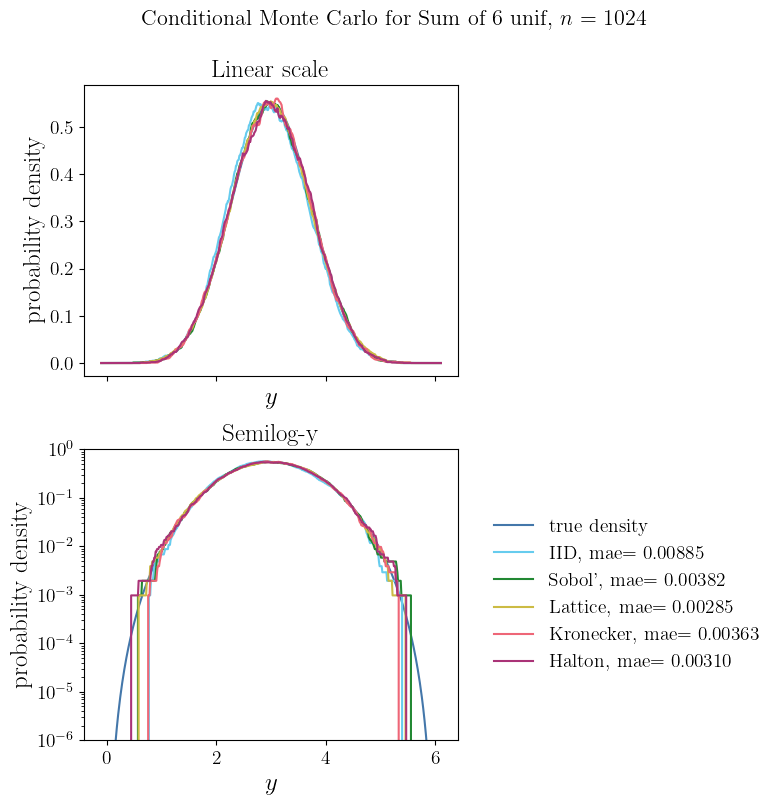

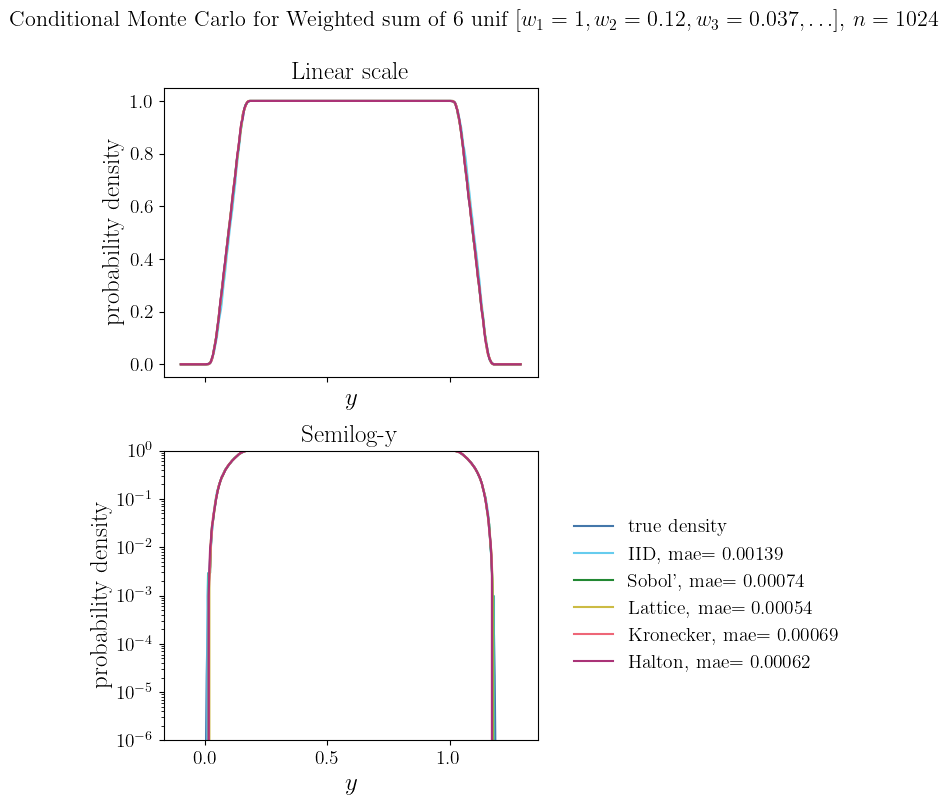

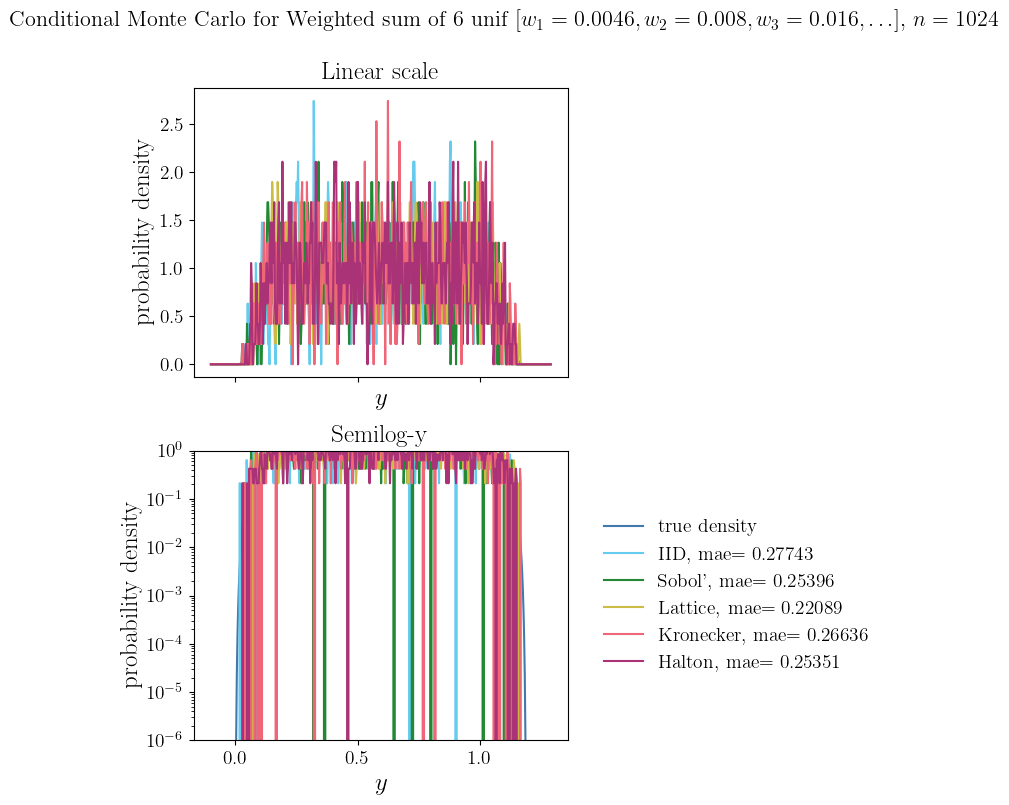

In [8]:
n = 2**10  #number of samples
d = 6   #dimension
sampler_list = ["iid", "sobol"]
nplot = 500 #number of points to plot the density at
wh_err = "mae"
coord_wts_list = [
    np.ones(d),                          # equal weights
    np.arange(1, d+1)**-3.,               # your example
    np.arange(d, 0, -1)**-3.,             # another example
]
ex_density = sum_d_unif_case(False)

for coord_wts in coord_wts_list:
    dens_kwargs = {"d" : d, "coord_wts" : coord_wts}
    plt_domain = ex_density["y_plt_domain"](**dens_kwargs) 
    the_y_domain = ex_density["y_domain"](**dens_kwargs)
    yplot = np.linspace(plt_domain[0],plt_domain[1],nplot)
    rhoexact = ex_density["density"](yplot,**dens_kwargs)
    f = ex_density["f"]
    fig, axes = plt.subplots(2,1, figsize=(8,8), sharex=True)
    
    for j, ax in enumerate(axes):
        ax.plot(yplot, rhoexact, label="true density")
        for key in samplers:
            x = samplers[key]["gen"](d, n)
            rhoapp_cmc = cmc(ex_density["gprime"], x, yplot, **dens_kwargs)
            err_cmc = error_rho(rhoexact, rhoapp_cmc, kind_of_err=[wh_err])
            ax.plot(yplot, rhoapp_cmc,
                    label=f'{samplers[key]["label"]}, {wh_err}$={err_cmc[wh_err]:.5f}$')
    
        ax.set_xlabel("$y$")
        ax.set_ylabel("probability density")
        if j == 1:
            ax.set_yscale("log")
            ax.set_title("Semilog-y")
            ax.set_ylim(1e-6,1)
        else:
            ax.set_title("Linear scale")
    
    axes[1].legend(loc="center left", bbox_to_anchor=(1.05, 0.5), frameon=False)
    fig.suptitle(
        f'Conditional Monte Carlo for {ex_density["name"](**dens_kwargs)}, $n={n}$',
        fontsize=16,
        y=1  # raise it a bit above the subplots
    )
    fig.tight_layout()